In [1]:
%load_ext autoreload
%autoreload 2

from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader

import torch
from torch.utils.data import Dataset
import torch.distributions as D

from propose.models.flows import CondGraphFlow
from propose.models.flows.Flow import NF

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from propose.training import supervised_trainer

In [2]:
epochs = 200
lr = 0.001
weight_decay = 0

In [3]:
class TwoPointDataset(Dataset):
    def __init__(self, n_items_full=100, n_items_subset_1=100, n_items_subset_2=100, prior=None, graph=True):
        self.graph = graph

        if prior is None:
            prior = D.MultivariateNormal(torch.zeros(2), torch.eye(2))

        data_list = []
        prior_data_list = []

        for i in range(n_items_full):
            data = HeteroData()

            direction = torch.randn(1, 1, 2)
#             direction[..., 2] = torch.randn(1, 1) / 5
            direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1) + torch.randn(1, 1, 1) * 0.01

            M1 = prior.sample((1,))
            M2 = (M1 + direction).squeeze(0)

            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['c'].x = data['x'].x[..., :2] + 0.1 * torch.randn(2, 2)

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 0], [1, 1]]).T
            data['x', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<-', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data_list.append(data)
            
            data = HeteroData()
            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['x', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<-', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            prior_data_list.append(data)

        for i in range(n_items_subset_1):
            data = HeteroData()

            direction = torch.randn(1, 1, 2)
#             direction[..., 2] = torch.randn(1, 1) / 5
            direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1) + torch.randn(1, 1, 1) * 0.01

            M1 = prior.sample((1,))
            M2 = (M1 + direction).squeeze(0)

            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['c'].x = data['x'].x[..., :2][0].unsqueeze(0) + 0.1 * torch.randn(1, 2)

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 0]]).T
            data['x', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<-', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data_list.append(data)
            
            data = HeteroData()
            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['x', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<-', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            prior_data_list.append(data)

        for i in range(n_items_subset_2):
            data = HeteroData()

            direction = torch.randn(1, 1, 2)
#             direction[..., 2] = torch.randn(1, 1) / 5
            direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1) + torch.randn(1, 1, 1) * 0.01

            M1 = prior.sample((1,))
            M2 = (M1 + direction).squeeze(0)

            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['c'].x = data['x'].x[..., :2][1].unsqueeze(0) + 0.1 * torch.randn(1, 2)

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<-', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data_list.append(data)
            
            data = HeteroData()
            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['x', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<-', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            prior_data_list.append(data)

        self.data = data_list
        self.prior_data = prior_data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.graph:
            return self.data[idx], self.prior_data[idx], torch.zeros(1)
    
        return [self.data[idx]['x']['x'], self.data[idx]['c']['x']], self.prior_data[idx]['x']['x'], torch.zeros(1)

    def metadata(self):
        return self.data[0].metadata()

In [4]:
dataset = TwoPointDataset(n_items_full=1000, n_items_subset_1=1000, n_items_subset_2=1000)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

In [5]:
flow = CondGraphFlow(num_layers=10, features=2, context_features=2, hidden_features=100)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)

In [50]:
flow.load_state_dict(torch.load('./models/cgnf_2_pts.pt'))
flow.eval();

In [7]:
prior_data = HeteroData({
    'x': {'x': torch.zeros(2, 2), 'batch': torch.Tensor([0, 1])},
    ('x', '->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('x', '<-', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
})

part_data_1 = HeteroData({
    'x': {'x': torch.zeros(2, 2), 'batch': torch.Tensor([0, 1])},
    'c': {'x': torch.Tensor([[0, 0]]), 'batch': torch.Tensor([0])},
    ('x', '->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('x', '<-', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('c',  '->', 'x'): { 'edge_index': torch.LongTensor([[0, 0]]).T }
})

part_data_2 = HeteroData({
    'x': {'x': torch.zeros(2, 2), 'batch': torch.Tensor([0, 1])},
    'c': {'x': torch.Tensor([[0, 0]]), 'batch': torch.Tensor([0])},
    ('x', '->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('x', '<-', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('c',  '->', 'x'): { 'edge_index': torch.LongTensor([[0, 1]]).T }
})

posterior_data = HeteroData({
    'x': {'x': torch.zeros(2, 2), 'batch': torch.Tensor([0, 1])},
    'c': {'x': torch.Tensor([[0, 0], [1, 0]]), 'batch': torch.Tensor([0])},
    ('x', '->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('x', '<-', 'x'): { 'edge_index' : torch.LongTensor([[0, 1]]).T },
    ('c',  '->', 'x'): { 'edge_index': torch.LongTensor([[0, 0], [1, 1]]).T }
})

part_1_samples = flow.sample(100000, part_data_1)
part_2_samples = flow.sample(100000, part_data_2)
prior_samples = flow.sample(100000, prior_data)
posterior_samples = flow.sample(100000, posterior_data)

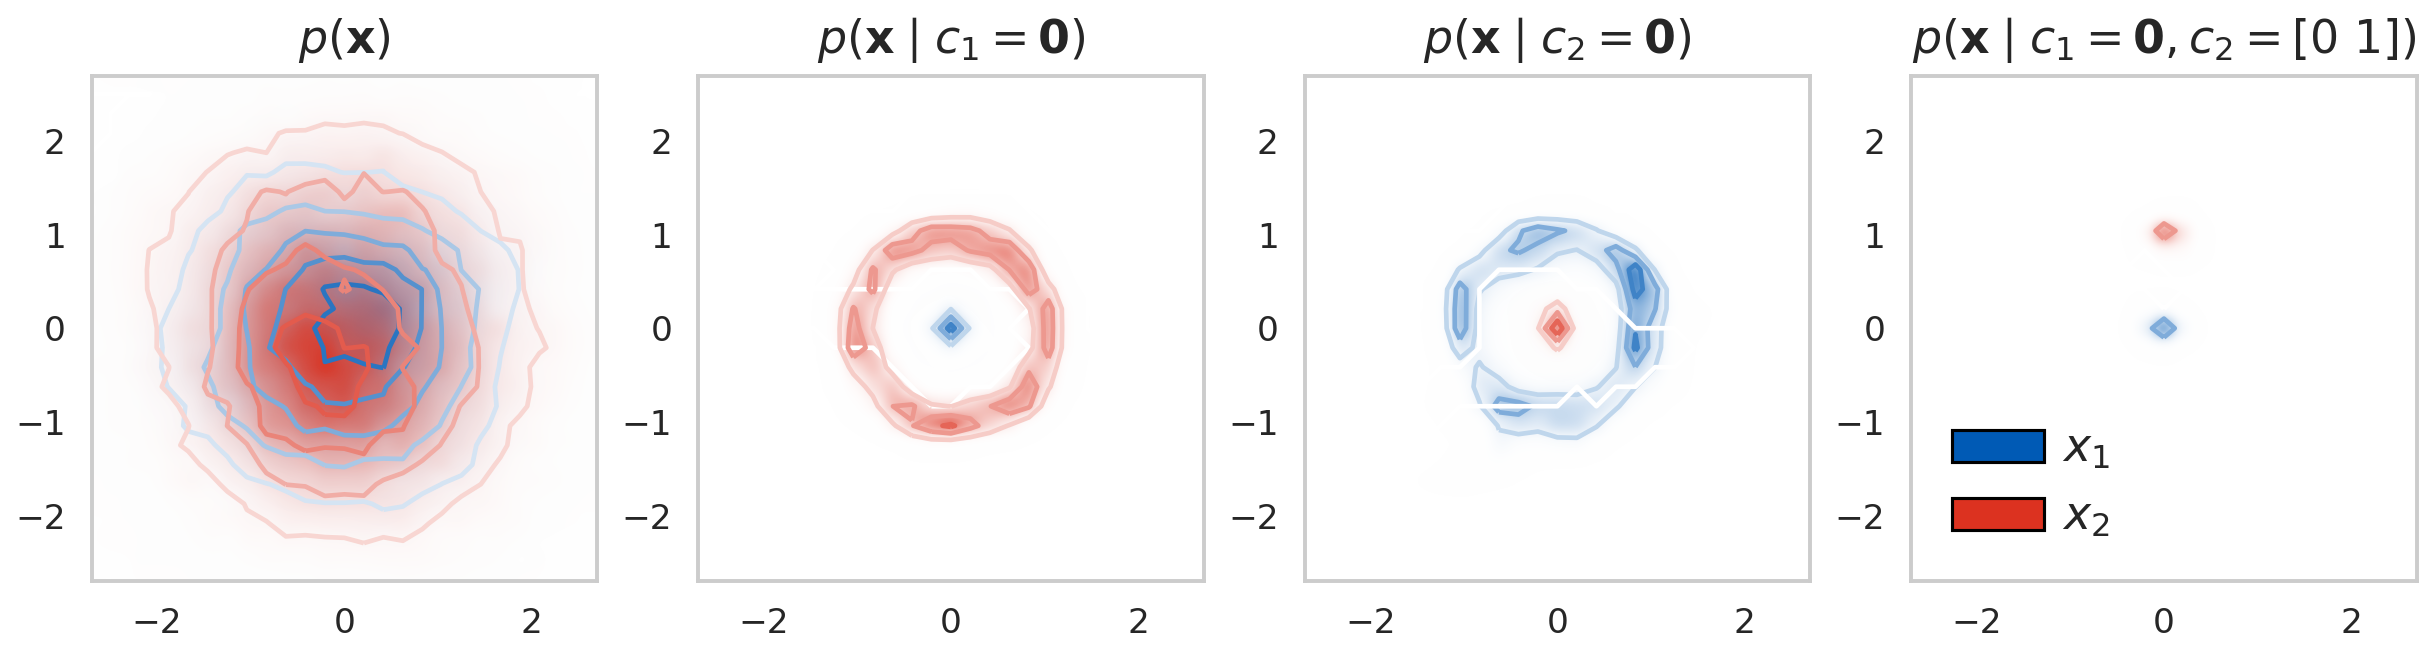

In [88]:
midblue = '#00def8'
goeblue = '#153268'
xlim = (-2.7, 2.7)
ylim = (-2.7, 2.7)
x1_color = '#005ab5'
x2_color = '#dc3220'

cm = sns.blend_palette([(1, 1, 1, 0), x1_color], as_cmap=True)
cm2 = sns.blend_palette([(1, 1, 1, 0), x1_color], as_cmap=True)
# dc3220
# 005ab5
cm3 = sns.blend_palette([(1, 1, 1, 0), x2_color], as_cmap=True)
cm4 = sns.blend_palette([(1, 1, 1, 0), x2_color], as_cmap=True)

with sns.axes_style('whitegrid'):
    sns.set_context('talk')
    plt.figure(figsize=(20, 5), dpi=150)
    
    plt.subplot(1, 4, 1)
    samps = prior_samples['x']['x'].swapaxes(0, 1).data.numpy()
    hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
    hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)
    
    plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
    plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
    plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=5)
    plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=5)
    plt.grid(False)
    plt.title('$p(\\mathbf{x})$', fontsize=22, y=1.02)
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.subplot(1, 4, 2)
    samps = part_1_samples['x']['x'].swapaxes(0, 1).data.numpy()
    hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
    hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)
    
    plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
    plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
    plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=3)
    plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=3)
    plt.grid(False)
    plt.title('$p(\\mathbf{x} \mid c_1 = \mathbf{0})$', fontsize=22, y=1.02)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.subplot(1, 4, 3)
    samps = part_2_samples['x']['x'].swapaxes(0, 1).data.numpy()
    hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
    hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)
    
    plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
    plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
    plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=3)
    plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=3)
    plt.grid(False)
    plt.title('$p(\\mathbf{x} \mid c_2 = \mathbf{0})$', fontsize=22, y=1.02)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.subplot(1, 4, 4)
    samps = posterior_samples['x']['x'].swapaxes(0, 1).data.numpy()
    hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
    hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)
    
    plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
    plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
    plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=1)
    plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=1)
    plt.grid(False)
    plt.title('$p(\\mathbf{x} \mid c_1 = \\mathbf{0}, c_2 = [0 \ 1])$', fontsize=22, y=1.02)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # legend
    plt.bar([-10], [0], color=x1_color, edgecolor='k', label='$x_1$')
    plt.bar([-10], [0], color=x2_color, edgecolor='k', label='$x_2$')
    plt.legend(loc="lower left", frameon=False, handletextpad=0.4, fontsize=22)
    
#     plt.savefig('./two_points.png', dpi=100, bbox_inches='tight')
#     plt.savefig('./two_points.pdf', dpi=100, bbox_inches='tight')
    
    plt.show()

In [102]:
def set_axis_color(ax, color):
    for k, v in ax.spines.items():
        v.set_color(color)
    ax.tick_params(colors=color)

In [153]:
plt.rcParams["axes.axisbelow"] = False

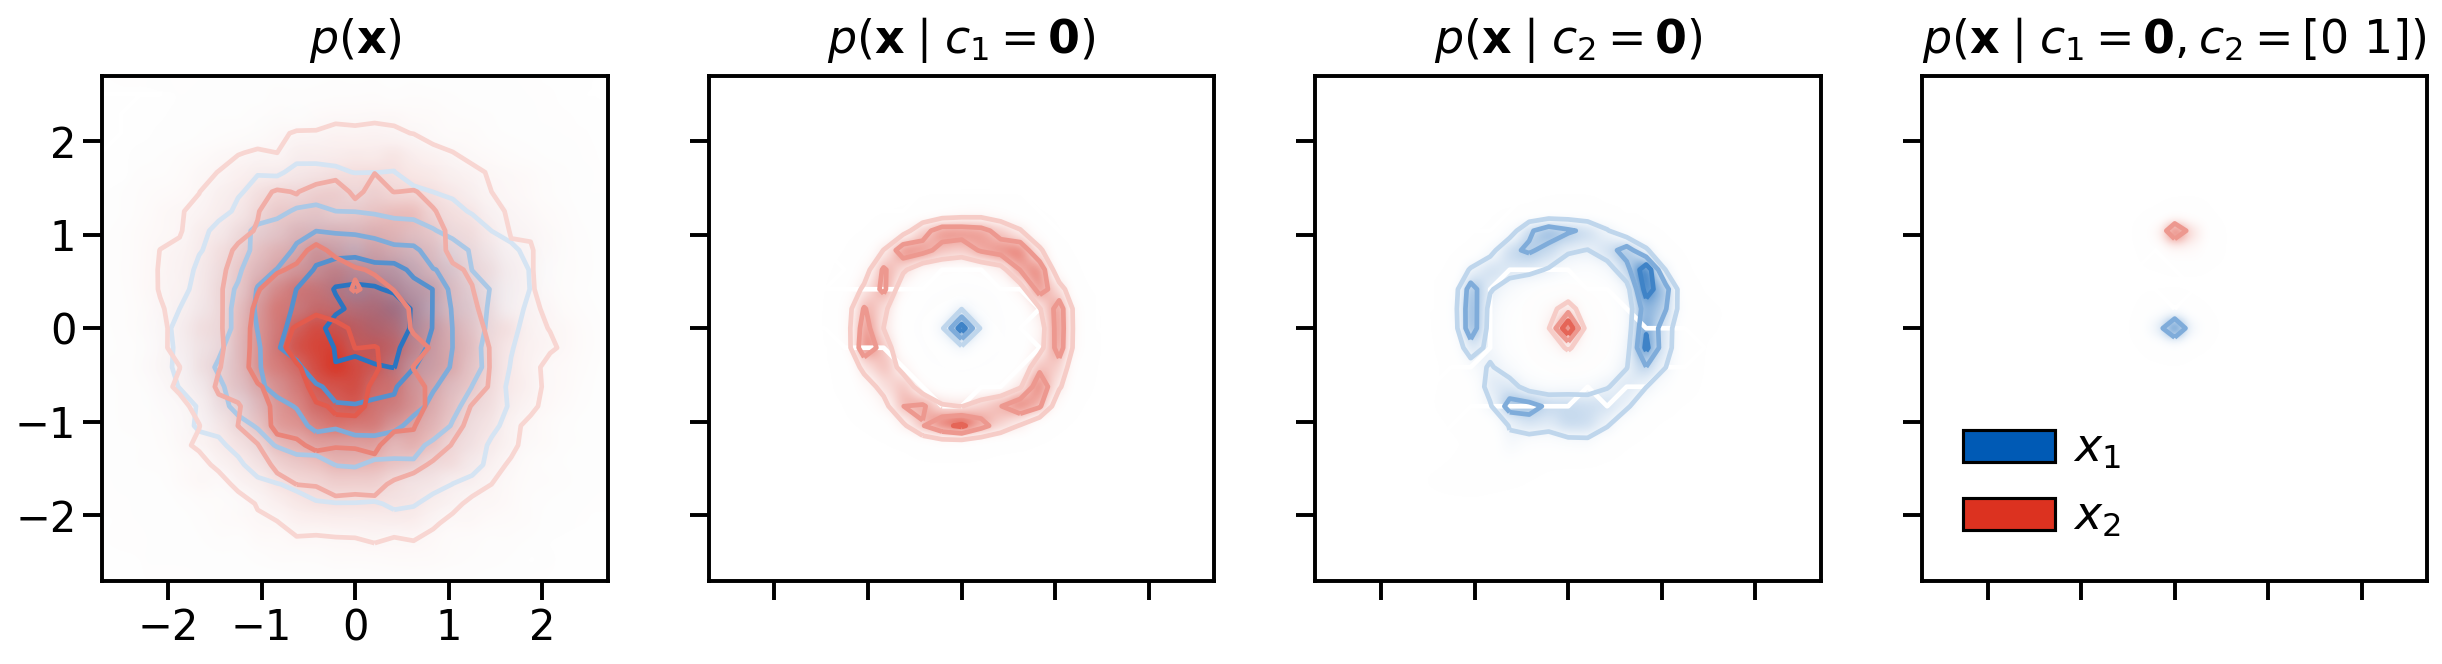

In [371]:
midblue = '#00def8'
goeblue = '#153268'
xlim = (-2.7, 2.7)
ylim = (-2.7, 2.7)
x1_color = '#005ab5'
x2_color = '#dc3220'
edgecolor = "k" #'.5'
tick_direction = "out"

cm = sns.blend_palette([(1, 1, 1, 0), x1_color], as_cmap=True)
cm2 = sns.blend_palette([(1, 1, 1, 0), x1_color], as_cmap=True)
cm3 = sns.blend_palette([(1, 1, 1, 0), x2_color], as_cmap=True)
cm4 = sns.blend_palette([(1, 1, 1, 0), x2_color], as_cmap=True)

plt.figure(figsize=(20, 5), dpi=150)

plt.subplot(1, 4, 1)
samps = prior_samples['x']['x'].swapaxes(0, 1).data.numpy()
hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)

plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=5)
plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=5)
plt.grid(False)
plt.title('$p(\\mathbf{x})$', fontsize=22, y=1.02)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(ticks=[-2, -1, 0, 1, 2], fontsize=20)
plt.yticks(ticks=[-2, -1, 0, 1, 2], fontsize=20)
set_axis_color(plt.gca(), edgecolor)
plt.gca().tick_params(direction=tick_direction)

plt.subplot(1, 4, 2)
samps = part_1_samples['x']['x'].swapaxes(0, 1).data.numpy()
hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)

plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=3)
plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=3)
plt.grid(False)
plt.title('$p(\\mathbf{x} \mid c_1 = \mathbf{0})$', fontsize=22, y=1.02)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(ticks=[-2, -1, 0, 1, 2], labels=[])
plt.yticks(ticks=[-2, -1, 0, 1, 2], labels=[])
set_axis_color(plt.gca(), edgecolor)
plt.gca().tick_params(direction=tick_direction)

plt.subplot(1, 4, 3)
samps = part_2_samples['x']['x'].swapaxes(0, 1).data.numpy()
hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)

plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True) 
cs = plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=3) 
plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=3)

plt.grid(False)
plt.title('$p(\\mathbf{x} \mid c_2 = \mathbf{0})$', fontsize=22, y=1.02)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(ticks=[-2, -1, 0, 1, 2], labels=[])
plt.yticks(ticks=[-2, -1, 0, 1, 2], labels=[])
set_axis_color(plt.gca(), edgecolor)
plt.gca().tick_params(direction=tick_direction)
plt.gca().set_axisbelow(False)

plt.subplot(1, 4, 4)
samps = posterior_samples['x']['x'].swapaxes(0, 1).data.numpy()
hist, _, _ = np.histogram2d(samps[:, 0, 0], samps[:, 0, 1], bins=np.linspace(-5, 5, 50), density=True)
hist2, _, _ = np.histogram2d(samps[:, 1, 0], samps[:, 1, 1], bins=np.linspace(-5, 5, 50), density=True)

plt.imshow(hist2, extent=[-5, 5, -5, 5], origin='lower', cmap=cm3, alpha=hist2 / hist2.max(), interpolation='gaussian', rasterized=True)
plt.imshow(hist, extent=[-5, 5, -5, 5], origin='lower', cmap=cm, alpha=hist / hist.max(), interpolation='gaussian', rasterized=True)
plt.contour(hist, extent=[-5, 5, -5, 5], cmap=cm2, levels=1)
plt.contour(hist2, extent=[-5, 5, -5, 5], cmap=cm4, levels=1)
plt.grid(False)
plt.title('$p(\\mathbf{x} \mid c_1 = \\mathbf{0}, c_2 = [0 \ 1])$', fontsize=22, y=1.02)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(ticks=[-2, -1, 0, 1, 2], labels=[])
plt.yticks(ticks=[-2, -1, 0, 1, 2], labels=[])
set_axis_color(plt.gca(), edgecolor)
plt.gca().tick_params(direction=tick_direction)

# ax.spines['bottom'].set_color(edgecolor)
# ax.spines['top'].set_color(edgecolor) 
# ax.spines['right'].set_color(edgecolor)
# ax.spines['left'].set_color(edgecolor)
# ax.tick_params(axis='x', colors=edgecolor)

# legend
plt.bar([-10], [0], color=x1_color, edgecolor='k', label='$x_1$')
plt.bar([-10], [0], color=x2_color, edgecolor='k', label='$x_2$')
plt.legend(loc="lower left", frameon=False, handletextpad=0.4, fontsize=22)

# sns.despine(top=True)

# plt.savefig('./two_points.png', dpi=100, bbox_inches='tight')
# plt.savefig('./two_points.pdf', dpi=100, bbox_inches='tight')
plt.savefig('./two_points.eps', dpi=100, bbox_inches='tight')

plt.show()

In [160]:
dataset.graph = True
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [161]:
nfs = {
    'x': NF(4, context_features=2, num_layers=20, hidden_features=(100, 200, 100)),
    'x|c1': NF(4, context_features=2, num_layers=20, hidden_features=200),
    'x|c2': NF(4, context_features=2, num_layers=20, hidden_features=200),
    'x|c1,c2': NF(4, context_features=4, num_layers=10, hidden_features=20),
}
optimizers = {
    key: torch.optim.Adam(nfs[key].parameters(), lr=lr, weight_decay=weight_decay)
    for key in nfs.keys()
}

datasets = {
    'x': TwoPointDataset(n_items_full=1000, n_items_subset_1=0, n_items_subset_2=0, graph=False),
    'x|c1': TwoPointDataset(n_items_full=0, n_items_subset_1=1000, n_items_subset_2=0, graph=False),
    'x|c2': TwoPointDataset(n_items_full=0, n_items_subset_1=0, n_items_subset_2=1000, graph=False),
    'x|c1,c2': TwoPointDataset(n_items_full=1000, n_items_subset_1=0, n_items_subset_2=0, graph=False),
}

dataloaders = {
    key: DataLoader(datasets[key], batch_size=100, shuffle=True)
    for key in datasets.keys()
}

In [162]:
for key in nfs:
    nfs[key].load_state_dict(torch.load(f'./models/cnf_{key}_2_pts.pt'))
    nfs[key].eval()

In [163]:
total = 0
for key in nfs:
    params = sum(p.numel() for p in nfs[key].parameters())
    total += params
    print(f'{key:>7}:  {params:,}')
print('='*15)
print(f'{"Total":>7}: {total:,}')

      x:  824,240
   x|c1:  36,240
   x|c2:  36,240
x|c1,c2:  2,320
  Total: 899,040


In [164]:
def gen_samps(key, n_samps=100):
    if key == 'x':
        prior = D.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2))

        x1 = prior.sample((n_samps,))
        direction = torch.randn(n_samps, 2)
        direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1) + torch.randn(n_samps, 1) * 0.01
        x2 = x1 + direction

        return x1, x2

    if key == 'x|c1':
        prior = D.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=0.001 * torch.eye(2))

        x1 = prior.sample((n_samps,))
        direction = torch.randn(n_samps, 2)
        direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1) + torch.randn(n_samps, 1) * 0.01
        x2 = x1 + direction

        return x1, x2
    
    if key == 'x|c2':
        prior = D.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=0.001 * torch.eye(2))

        x1 = prior.sample((n_samps,))
        direction = torch.randn(n_samps, 2)
        direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1) + torch.randn(n_samps, 1) * 0.01
        x2 = x1 + direction

        return x2, x1
    
    if key == 'x|c1,c2':
        prior = D.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=0.001 * torch.eye(2))
        prior2 = D.MultivariateNormal(loc=torch.Tensor([1, 0]), covariance_matrix=0.001 * torch.eye(2))

        x1 = prior.sample((n_samps,))
        x2 = prior2.sample((n_samps,))

        return x2, x1

In [176]:
test_graph_datasets = {
    'x': TwoPointDataset(n_items_full=1000, n_items_subset_1=0, n_items_subset_2=0, graph=True),
    'x|c1': TwoPointDataset(n_items_full=0, n_items_subset_1=1000, n_items_subset_2=0, graph=True),
    'x|c2': TwoPointDataset(n_items_full=0, n_items_subset_1=0, n_items_subset_2=1000, graph=True),
    'x|c1,c2': TwoPointDataset(n_items_full=1000, n_items_subset_1=0, n_items_subset_2=0, graph=True),
}

test_graph_dataloaders = {
    key: DataLoader(test_graph_datasets[key], batch_size=100, shuffle=True)
    for key in test_graph_datasets.keys()
}

In [177]:
results = {
    'cGNF': {},
    'CNF': {},
    'Oracle': {},
    'Ind': {}
}

In [178]:
key = 'x'

p_x1 = D.MultivariateNormal(loc=torch.Tensor([[0, 0]]), covariance_matrix=torch.eye(2))
p_x2_x1 = D.Normal(loc=1, scale=0.1)

x1, x2 = gen_samps('x')

dist = torch.norm(x1 - x2.squeeze(), dim=1)

log_p_x1 = p_x1.log_prob(x1)
log_p_x2_x1 = p_x2_x1.log_prob(dist)
log_p = log_p_x2_x1 + log_p_x1
c, d = log_p.mean(), (p_x1.log_prob(x1) + p_x1.log_prob(x2)).mean()

results['Oracle'][key] = c
results['Ind'][key] = d

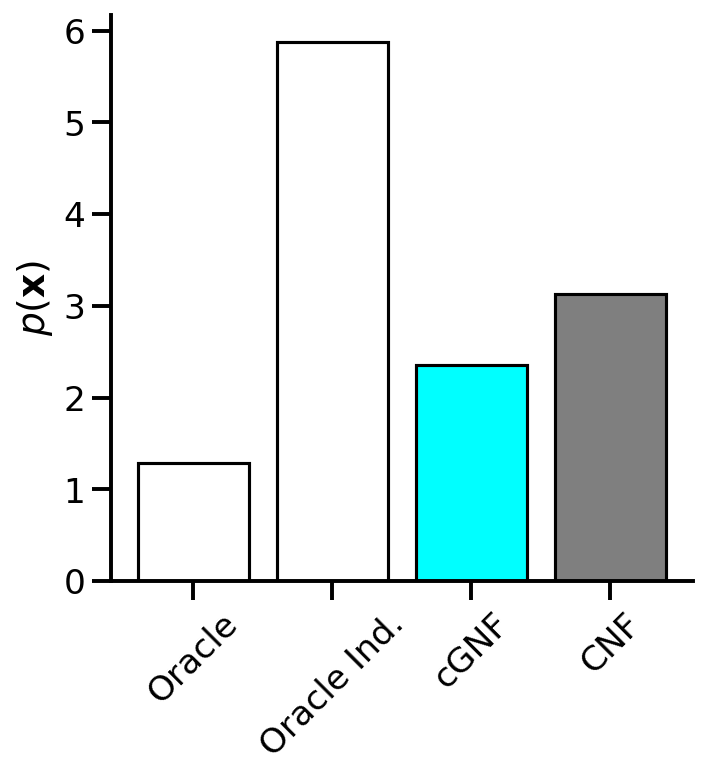

(array(-2.352874, dtype=float32), array(-3.133777, dtype=float32))

In [179]:
key = 'x'
frame = next(iter(test_graph_dataloaders[key]))[1]

log_probs = []
nf_log_probs = []

for i in range(10):
    x1, x2 = gen_samps(key)
    x2 = x2.squeeze()
    frame['x']['x'] = torch.stack([x1, x2], 1).flatten(0, 1)

    lp = flow.log_prob(frame)
    log_probs.append(lp.reshape(-1, 2).sum(1))
    nf_log_probs.append(nfs[key].log_prob(torch.stack([x1, x2], 1).flatten(1, 2), torch.zeros(100, 2)))
    
a, b = torch.cat(log_probs).mean().cpu().data.numpy(), torch.cat(nf_log_probs).mean().cpu().data.numpy()

results['cGNF'][key] = a
results['CNF'][key] = b

plt.figure(figsize=(5, 5), dpi=150)
plt.bar([0, 1, 2, 3], [-c, -d, -a, -b], color=['w', 'w', 'cyan', 'tab:gray'], edgecolor='black')
plt.xticks([0, 1, 2, 3], ['Oracle', 'Oracle Ind.', 'cGNF', 'CNF'], rotation=45)
plt.ylabel('$p(\\mathbf{x})$')
plt.grid(None)
sns.despine()
plt.grid(False)
plt.show()

a, b

In [180]:
p_x1 = D.MultivariateNormal(loc=torch.Tensor([[0, 0]]), covariance_matrix=0.01*torch.eye(2))
p_x2_x1 = D.Normal(loc=1, scale=0.1)

key = 'x|c1'
x1, x2 = gen_samps('x|c1')

dist = torch.norm(x1 - x2.squeeze(), dim=1)

log_p_x1 = p_x1.log_prob(x1)
log_p_x2_x1 = p_x2_x1.log_prob(dist)
log_p = log_p_x2_x1 + log_p_x1
c, d = log_p.mean(), (p_x1.log_prob(x1) + p_x1.log_prob(x2)).mean()
c, d

results['Oracle'][key] = c
results['Ind'][key] = d

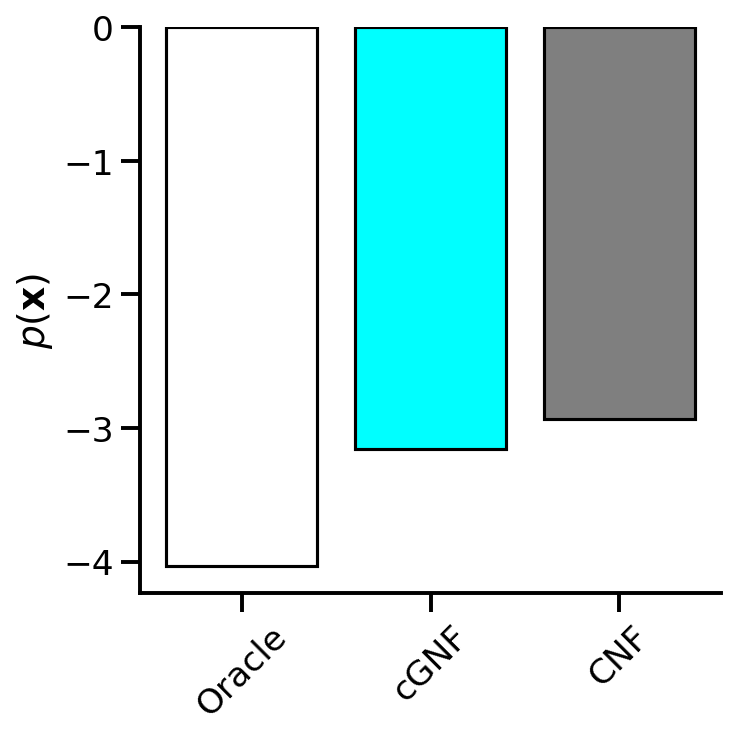

In [181]:
key = 'x|c1'
frame = next(iter(test_graph_dataloaders[key]))[0]

log_probs = []
nf_log_probs = []

for i in range(10):
    x1, x2 = gen_samps(key)
    x2 = x2.squeeze()
    frame['x']['x'] = torch.stack([x1, x2], 1).flatten(0, 1)
    frame['c']['x'] = torch.zeros(100, 2)

    log_probs.append(flow.log_prob(frame).reshape(-1, 2).sum(1))
    nf_log_probs.append(nfs[key].log_prob(torch.stack([x1, x2], 1).flatten(1, 2), frame['c']['x']))
    
a, b = torch.cat(log_probs).mean().cpu().data.numpy(), torch.cat(nf_log_probs).mean().cpu().data.numpy()

results['cGNF'][key] = a
results['CNF'][key] = b

plt.figure(figsize=(5, 5), dpi=150)
plt.bar([0, 1, 2], [-c, -a, -b], color=['w', 'cyan', 'tab:gray'], edgecolor='black')
plt.xticks([0, 1, 2], ['Oracle', 'cGNF', 'CNF'], rotation=45)
plt.ylabel('$p(\\mathbf{x})$')
plt.grid(None)
sns.despine()
plt.grid(False)
plt.show()

In [182]:
p_x1 = D.MultivariateNormal(loc=torch.Tensor([[0, 0]]), covariance_matrix=0.01*torch.eye(2))
p_x2_x1 = D.Normal(loc=1, scale=0.1)

key = 'x|c2'
x1, x2 = gen_samps('x|c2')
x2 = x2.squeeze()

dist = torch.norm(x1.squeeze() - x2.squeeze(), dim=1)

log_p_x1 = p_x1.log_prob(x2)
log_p_x2_x1 = p_x2_x1.log_prob(dist)
log_p = log_p_x2_x1 + log_p_x1
c, d = log_p.mean(), (p_x1.log_prob(x1) + p_x1.log_prob(x2)).mean()
c, d

x2.std()**2

results['Oracle'][key] = c
results['Ind'][key] = d

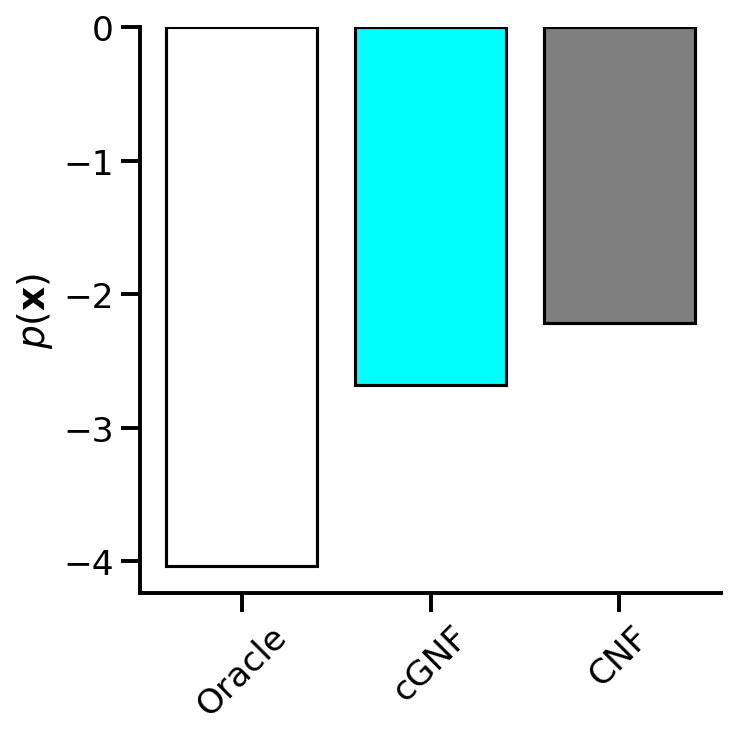

In [183]:
key = 'x|c2'
frame = next(iter(test_graph_dataloaders[key]))[0]

log_probs = []
nf_log_probs = []

for i in range(10):
    x1, x2 = gen_samps(key)
    x2 = x2.squeeze()
    x1 = x1.squeeze()
    frame['x']['x'] = torch.stack([x1, x2], 1).flatten(0, 1)
    frame['c']['x'] = torch.zeros(100, 2)

    log_probs.append(flow.log_prob(frame).reshape(-1, 2).sum(1))
    nf_log_probs.append(nfs[key].log_prob(torch.stack([x1, x2], 1).flatten(1, 2), frame['c']['x']))
    
a, b = torch.cat(log_probs).mean().cpu().data.numpy(), torch.cat(nf_log_probs).mean().cpu().data.numpy()

results['cGNF'][key] = a
results['CNF'][key] = b

plt.figure(figsize=(5, 5), dpi=150)
plt.bar([0, 1, 2], [-c, -a, -b], color=['w', 'cyan', 'tab:gray'], edgecolor='black')
plt.xticks([0, 1, 2], ['Oracle', 'cGNF', 'CNF'], rotation=45)
plt.ylabel('$p(\\mathbf{x})$')
plt.grid(None)
sns.despine()
plt.grid(False)
plt.show()

In [184]:
p_x1 = D.MultivariateNormal(loc=torch.Tensor([[1, 0]]), covariance_matrix=0.005*torch.eye(2))
p_x2 = D.MultivariateNormal(loc=torch.Tensor([[0, 0]]), covariance_matrix=0.005*torch.eye(2))

key = 'x|c1,c2'

log_p = []
for i in range(10):
    x1, x2 = gen_samps('x|c1,c2')
    x2 = x2.squeeze()

    # plt.figure(figsize=(5,5))
    # plt.scatter(*x1.T, alpha=0.1)
    # plt.scatter(*x2.T, alpha=0.1)
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    # plt.show()

    dist = torch.norm(x1.squeeze() - x2.squeeze(), dim=1)

    log_p_x1 = p_x1.log_prob(x1)
    log_p_x2_x1 = p_x2_x1.log_prob(dist)
    log_p.append(p_x1.log_prob(x1) + p_x2.log_prob(x2))

log_p = torch.cat(log_p)
c, d = log_p.mean(), (p_x1.log_prob(x1) + p_x1.log_prob(x2)).mean()
c, d

results['Oracle'][key] = c
results['Ind'][key] = d

results['Oracle'][key]

tensor(6.5138)

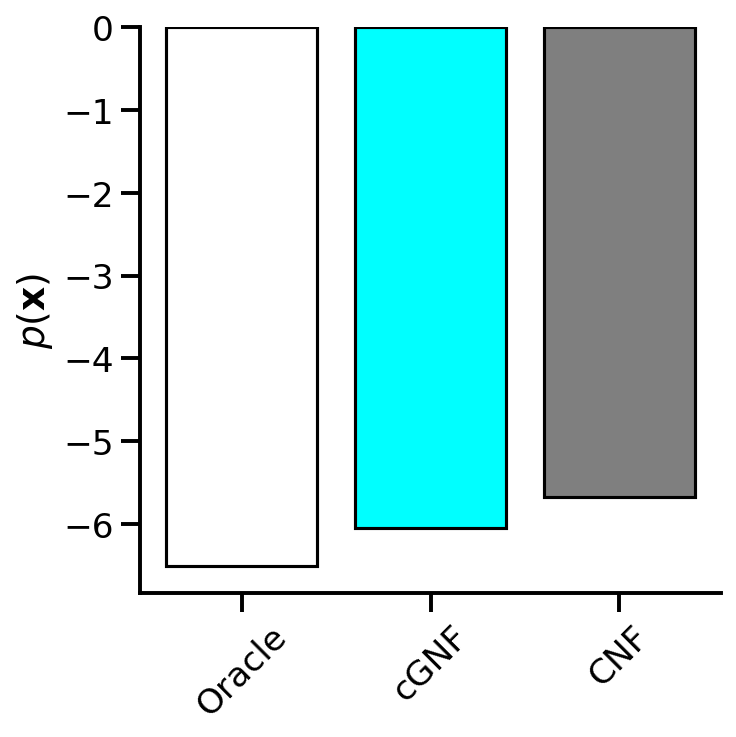

In [185]:
key = 'x|c1,c2'
frame = next(iter(test_graph_dataloaders[key]))[0]

log_probs = []
nf_log_probs = []

for i in range(10):
    x1, x2 = gen_samps(key)
    x2 = x2.squeeze()
    x1 = x1.squeeze()

    frame['x']['x'] = torch.stack([x1, x2], 1).flatten(0, 1)

    
    c2 = torch.zeros(100, 2)
    c1 = torch.Tensor([1, 0]).repeat(100, 1)
    frame['c']['x'] = torch.stack([c1, c2], 1).flatten(0, 1)
    
    log_probs.append(flow.log_prob(frame).reshape(-1, 2).sum(1))
    nf_log_probs.append(nfs[key].log_prob(torch.stack([x1, x2], 1).flatten(1, 2), torch.stack([c1, c2], 1).flatten(1, 2)))
    
a, b = torch.cat(log_probs).mean().cpu().data.numpy(), torch.cat(nf_log_probs).mean().cpu().data.numpy()

results['cGNF'][key] = a
results['CNF'][key] = b

plt.figure(figsize=(5, 5), dpi=150)
plt.bar([0, 1, 2], [-c, -a, -b], color=['w', 'cyan', 'tab:gray'], edgecolor='black')
plt.xticks([0, 1, 2], ['Oracle', 'cGNF', 'CNF'], rotation=45)
plt.ylabel('$p(\\mathbf{x})$')
plt.grid(None)
sns.despine()
plt.grid(False)
plt.show()

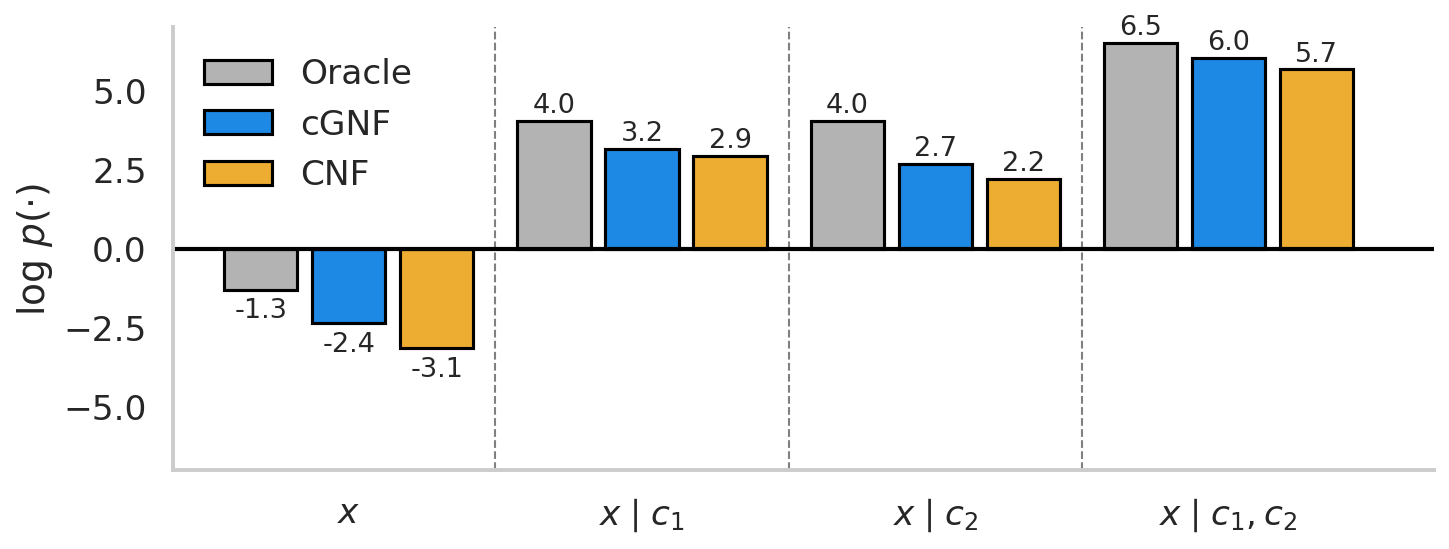

In [206]:
key_map = {
    'x': 'x',
    'x|c1': 'x\\mid c_1',
    'x|c2': 'x\\mid c_2',
    'x|c1,c2': 'x\\mid c_1, c_2'
}

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(10, 4), dpi=150)
    for i, key in enumerate(results['Oracle']):
        typ = ['Oracle', 'cGNF', 'CNF']
        plt.bar([0 + i, 0.3 + i, 0.6 + i], [results[t][key] for t in typ], width=0.25, edgecolor='k', color=['.7', '#1E88E5', '#EDAC32'])
        
        for idx, t in enumerate(typ):
            if results[t][key] > 0:
#                 plt.text(0 + i + 0.3 * idx - 0.07, results[t][key] + 0.25, f"{results[t][key]:.1f}", fontsize=10)
                plt.text(i + .3 * idx, results[t][key] + 0.25, f"{results[t][key]:.1f}", fontsize=13, ha="center")
            
            if results[t][key] < 0:
#                 plt.text(0 + i + 0.3 * idx - 0.1, results[t][key] - 0.8, f"{results[t][key]:.1f}", fontsize=10)
                plt.text(i + .3 * idx, results[t][key] - 0.9, f"{results[t][key]:.1f}", fontsize=13, ha="center")
    
    plt.xticks([0.3, 1.3, 2.3, 3.3], [f'${key_map[key]}$' for key in results['Oracle']], rotation=0)
    plt.ylim(-7, 7)
    plt.xlim(-.3, 4)
    plt.grid(False)
    
    plt.axvline(0.8, c='gray', lw=1, ls='--')
    plt.axvline(1.8, c='gray', lw=1, ls='--')
    plt.axvline(2.8, c='gray', lw=1, ls='--')
    plt.axhline(0, c='k', lw=2)
    
    
    plt.bar([-10], [0], color='.7', edgecolor='k', label='Oracle')
    plt.bar([-10], [0], color='#1E88E5', edgecolor='k', label='cGNF')
    plt.bar([-10], [0], color='#EDAC32', edgecolor='k', label='CNF')
    plt.legend(frameon=True, framealpha=1, edgecolor='w')
    
    plt.ylabel('$\\log\ p(\cdot)$')
    
    sns.despine()
    
    plt.tight_layout()
    
# plt.savefig('./results_two_points.png', dpi=100, bbox_inches='tight')
# plt.savefig('./results_two_points.pdf', dpi=100, bbox_inches='tight')
plt.show()

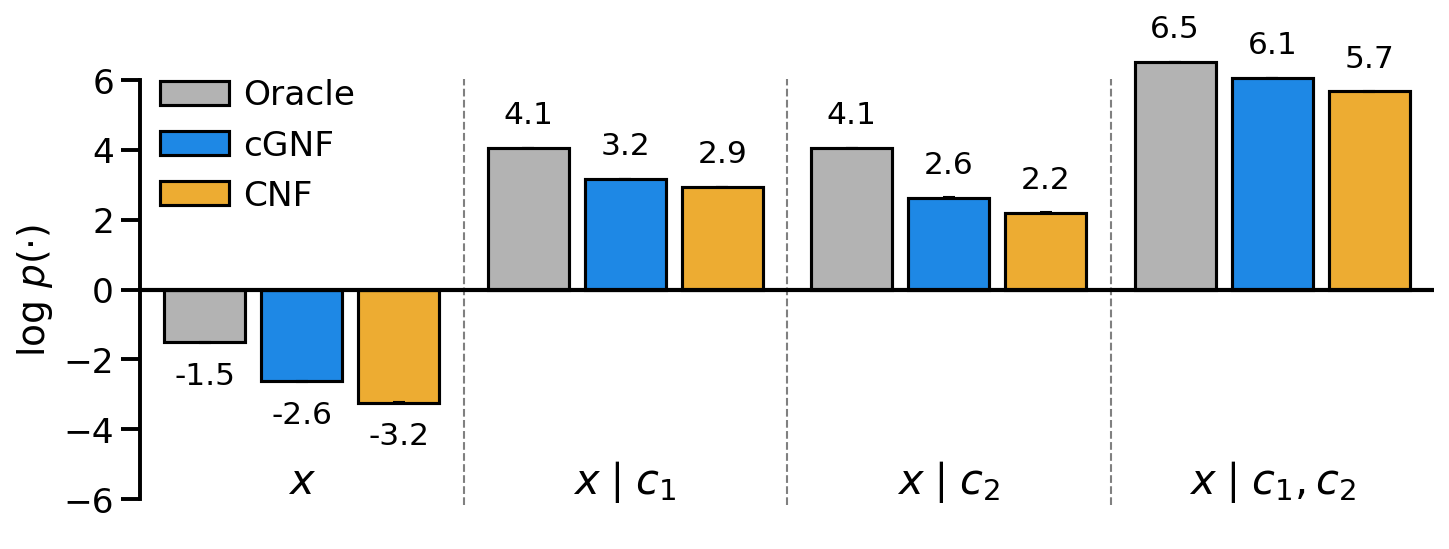

In [388]:
key_map = {
    'x': 'x',
    'x|c1': 'x\\mid c_1',
    'x|c2': 'x\\mid c_2',
    'x|c1,c2': 'x\\mid c_1, c_2'
}

colors = {"Oracle": ".7", "cGNF": "#1E88E5", "CNF": "#EDAC32"}

# imported values from two_points_2.ipynb where they were computed
res = {'cGNF': {'x': {'mean': -2.628487, 'sem': 0.038997738970305826},
  'x|c1': {'mean': 3.1691427, 'sem': 0.012139178301826141},
  'x|c2': {'mean': 2.6304088, 'sem': 0.022750387605825127},
  'x|c1,c2': {'mean': 6.0530863, 'sem': 0.003838992368932362}},
 'CNF': {'x': {'mean': -3.2397265, 'sem': 0.022421908957422045},
  'x|c1': {'mean': 2.9401412, 'sem': 0.005704366862173776},
  'x|c2': {'mean': 2.2029693, 'sem': 0.006669422623649946},
  'x|c1,c2': {'mean': 5.6731524, 'sem': 0.0021019971645548385}},
 'Oracle': {'x': {'mean': -1.5153677, 'sem': 0.024204122954769897},
  'x|c1': {'mean': 4.0525475, 'sem': 0.00668518798608484},
  'x|c2': {'mean': 4.0544295, 'sem': 0.0029449134336724126},
  'x|c1,c2': {'mean': 6.5206285, 'sem': 0.004061314716973017}}}

plt.figure(figsize=(10, 4), dpi=150)
for i, key in enumerate(res['Oracle']):
    typ = ['Oracle', 'cGNF', 'CNF']
    plt.bar([0 + i, 0.3 + i, 0.6 + i], [res[t][key]['mean'] for t in typ], width=0.25, edgecolor='k', color=[colors[t] for t in typ], yerr=res[t][key]['sem'], capsize=3)#['.7', '#1E88E5', '#EDAC32'])

    for idx, t in enumerate(typ):
        if results[t][key] > 0:
            plt.text(i + .3 * idx, res[t][key]['mean'] + 0.7, f"{res[t][key]['mean']:.1f}", fontsize=15, ha="center")
        if results[t][key] < 0:
            plt.text(i + .3 * idx, res[t][key]['mean'] - 1.2, f"{res[t][key]['mean']:.1f}", fontsize=15, ha="center")

for idx, key in enumerate(results['Oracle']):
    plt.text(.3 + idx, -5.5, f'${key_map[key]}$', fontsize=20, ha="center", va="center", weight="bold")

plt.ylim(-7, 7)
plt.xlim(-.3, 4)
plt.grid(False)

plt.axvline(0.8, ymin=.06, ymax=.93, c='gray', lw=1, ls='--')
plt.axvline(1.8, ymin=.06, ymax=.93, c='gray', lw=1, ls='--')
plt.axvline(2.8, ymin=.06, ymax=.93, c='gray', lw=1, ls='--')
plt.axhline(0., c="k", lw=2)


plt.bar([-10], [0], color='.7', edgecolor='k', label='Oracle')
plt.bar([-10], [0], color='#1E88E5', edgecolor='k', label='cGNF')
plt.bar([-10], [0], color='#EDAC32', edgecolor='k', label='CNF')
plt.legend(loc=(0.005, .63), frameon=True, framealpha=0, edgecolor='w', handletextpad=.4)

plt.ylabel('$\\log\ p(\cdot)$')

plt.xticks([])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.xlim(-.2, 3.8)
sns.despine(trim=True, top=True, bottom=True)
set_axis_color(plt.gca(), "k")

plt.tight_layout()

# plt.savefig('./results_two_points.png', dpi=100, bbox_inches='tight')
# plt.savefig('./results_two_points.pdf', dpi=100, bbox_inches='tight')
# plt.savefig('./results_two_points.svg', dpi=100, bbox_inches='tight')

plt.show()

## Calibration

In [45]:
from tqdm import tqdm
test_graph_dataloaders_batch_1 = {
    key: DataLoader(test_graph_datasets[key], batch_size=1, shuffle=True)
    for key in test_graph_datasets.keys()
}
def calibration(flow, key):
    frame = next(iter(test_graph_dataloaders_batch_1[key]))[0]
    if key == 'x':
        frame = next(iter(test_graph_dataloaders_batch_1[key]))[1]
        
    total = 0
    
    quantiles = np.arange(0, 1.01, 0.01)
    quantile_counts = np.zeros((2, len(quantiles)))
    q_val = []
    
    for _ in tqdm(range(100)):
        x1, x2 = gen_samps(key, n_samps=1)
        x2 = x2.squeeze().unsqueeze(0)
        x1 = x1.squeeze().unsqueeze(0)

        frame['x']['x'] = torch.stack([x1, x2], 1).flatten(0, 1)

        c2 = torch.zeros(1, 2)
        c1 = torch.Tensor([1, 0]).repeat(1, 1)
        frame['c']['x'] = torch.zeros(1, 2)

        if key == 'x|c1,c2':
            frame['c']['x'] = torch.stack([c1, c2], 1).flatten(0, 1)
        
        samples = flow.sample(200, frame)["x"].x.detach().cpu().numpy()
        true_pose = frame['x']['x'].detach().cpu().unsqueeze(1).numpy()
        
        sample_mean = torch.Tensor(samples).median(1).values.numpy()[..., np.newaxis, :]
        errors = ((sample_mean - samples)**2).sum(-1)**.5
        true_error = ((sample_mean - true_pose)**2).sum(-1)**.5
        
        q_vals = np.quantile(errors, quantiles, 1)
        q_val.append(q_vals)

        v = (q_vals.T > true_error).astype(int)
        if not np.isnan(v).any():
            total += 1
            quantile_counts += v
        
        true_pose = np.insert(true_pose, 0, 0, axis=1)
        samples = np.insert(samples, 0, 0, axis=1)
        
    quantile_freqs = quantile_counts / total
    
    return quantiles, quantile_freqs, q_val

def nfs_calibration(nfs, key):
    frame = next(iter(test_graph_dataloaders_batch_1[key]))[0]
    total = 0
    
    quantiles = np.arange(0, 1.01, 0.01)
    quantile_counts = np.zeros((2, len(quantiles)))
    q_val = []
    
    for _ in tqdm(range(100)):
        x1, x2 = gen_samps(key, n_samps=1)
        x2 = x2.squeeze().unsqueeze(0)
        x1 = x1.squeeze().unsqueeze(0)

        frame['x']['x'] = torch.stack([x1, x2], 1).flatten(0, 1)

        c2 = torch.zeros(1, 2)
        c1 = torch.Tensor([1, 0]).repeat(1, 1)
        frame['c']['x'] = torch.zeros(1, 2)

        if key == 'x|c1,c2':
            frame['c']['x'] = torch.stack([c1, c2], 1).flatten().unsqueeze(0)
        
        samples = nfs[key].sample(200, frame['c']['x']).detach().cpu().numpy().reshape(2, 200, 2)
        true_pose = frame['x']['x'].detach().cpu().unsqueeze(1).numpy()
        
        sample_mean = torch.Tensor(samples).median(1).values.numpy()[..., np.newaxis, :]
        errors = ((sample_mean - samples)**2).sum(-1)**.5
        true_error = ((sample_mean - true_pose)**2).sum(-1)**.5
        
        q_vals = np.quantile(errors, quantiles, 1)
        q_val.append(q_vals)

        v = (q_vals.T > true_error).astype(int)
        if not np.isnan(v).any():
            total += 1
            quantile_counts += v
        
        true_pose = np.insert(true_pose, 0, 0, axis=1)
        samples = np.insert(samples, 0, 0, axis=1)
        
    quantile_freqs = quantile_counts / total
    
    return quantiles, quantile_freqs, q_val

In [51]:
quantiles = {
    'cGNF': {
        'x': {},
        'x|c1': {},
        'x|c2': {},
        'x|c1,c2': {},
    },
    'CNF': {
        'x': {},
        'x|c1': {},
        'x|c2': {},
        'x|c1,c2': {},
    }
}
for key in nfs.keys():
    quantiles['cGNF'][key]['quantiles'], quantiles['cGNF'][key]['quantile_freqs'], quantiles['cGNF'][key]['q_val'] = calibration(flow, key=key)
    quantiles['CNF'][key]['quantiles'], quantiles['CNF'][key]['quantile_freqs'], quantiles['CNF'][key]['q_val'] = nfs_calibration(nfs, key=key)

100%|██████████| 100/100 [00:02<00:00, 43.48it/s]


In [52]:
v_cgnf_obs = []
v_cgnf_uobs = []
v_cnf_obs = []
v_cnf_uobs = []
for key in quantiles['cGNF']:
    if key == 'x':
        v_cgnf_uobs.append(quantiles['cGNF'][key]['quantile_freqs'][0])
        v_cgnf_uobs.append(quantiles['cGNF'][key]['quantile_freqs'][1])

        v_cnf_uobs.append(quantiles['CNF'][key]['quantile_freqs'][0])
        v_cnf_uobs.append(quantiles['CNF'][key]['quantile_freqs'][1])
        
    if key == 'x|c1':
        v_cgnf_uobs.append(quantiles['cGNF'][key]['quantile_freqs'][1])
        v_cgnf_obs.append(quantiles['cGNF'][key]['quantile_freqs'][0])
        
        v_cnf_uobs.append(quantiles['CNF'][key]['quantile_freqs'][1])
        v_cnf_obs.append(quantiles['CNF'][key]['quantile_freqs'][0])
        
    if key == 'x|c2':
        v_cgnf_uobs.append(quantiles['cGNF'][key]['quantile_freqs'][0])
        v_cgnf_obs.append(quantiles['cGNF'][key]['quantile_freqs'][1])
        
        v_cnf_uobs.append(quantiles['CNF'][key]['quantile_freqs'][0])
        v_cnf_obs.append(quantiles['CNF'][key]['quantile_freqs'][1])
        
    if key == 'x|c1,c2':
        v_cgnf_obs.append(quantiles['cGNF'][key]['quantile_freqs'][0])
        v_cgnf_obs.append(quantiles['cGNF'][key]['quantile_freqs'][1])

        v_cnf_obs.append(quantiles['CNF'][key]['quantile_freqs'][0])
        v_cnf_obs.append(quantiles['CNF'][key]['quantile_freqs'][1])

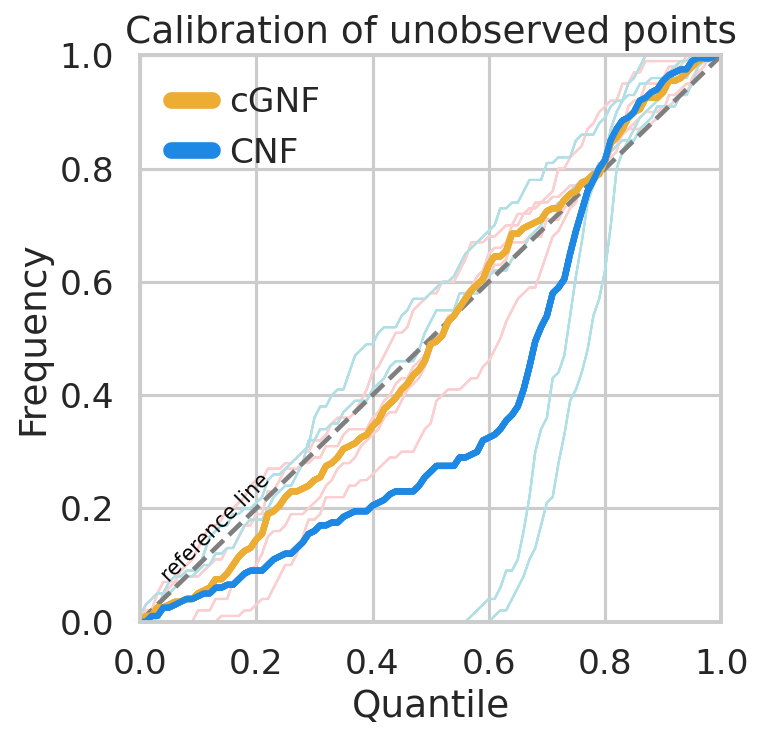

In [285]:
sns.set_context('talk')
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(5, 5), dpi=150)
    for key in quantiles['cGNF']:
#         plt.plot(quantiles['cGNF'][key]['quantiles'], np.stack(v_cgnf_obs).T, c='#FBCFCF', alpha=1, zorder=1, lw=1)
        plt.plot(quantiles['cGNF'][key]['quantiles'], np.stack(v_cgnf_uobs).T, c='#FBCFCF', alpha=1, zorder=1, lw=1)
        
#         plt.plot(quantiles['cGNF'][key]['quantiles'], np.median(np.stack(v_cgnf_obs), axis=0), c='deeppink', alpha=1, zorder=2, lw=3, label='Observed' if key == 'x' else None)
        plt.plot(quantiles['cGNF'][key]['quantiles'], np.median(np.stack(v_cgnf_uobs), axis=0), c='#EDAC32', alpha=1, zorder=2, lw=3, label='cGNF' if key == 'x' else None)

#         plt.plot(quantiles['CNF'][key]['quantiles'], quantiles['CNF'][key]['quantile_freqs'].T, c='#B0E0E6', alpha=1, zorder=1, lw=1)
        
#         plt.plot(quantiles['CNF'][key]['quantiles'], np.stack(v_cnf_obs).T, c='#B0E0E6', alpha=1, zorder=1, lw=1)
        plt.plot(quantiles['CNF'][key]['quantiles'], np.stack(v_cnf_uobs).T, c='#B0E0E6', alpha=1, zorder=1, lw=1)
        
#         plt.plot(quantiles['CNF'][key]['quantiles'], np.median(np.stack(v_cnf_obs), axis=0), c='#1E88E5', alpha=1, zorder=2, lw=3, label='Observed' if key == 'x' else None)
        plt.plot(quantiles['CNF'][key]['quantiles'], np.median(np.stack(v_cnf_uobs), axis=0), c='#1E88E5', alpha=1, zorder=2, lw=3, label='CNF' if key == 'x' else None)
#     plt.plot(quantiles['cGNF']['quantiles'], quantile_freqs.T[:, 0], c='#FBCFCF', alpha=1, zorder=1, label='cGNF')

#     plt.plot(quantiles, nf_quantile_freqs.T, c='#1E88E5', alpha=1, zorder=1)
#     plt.plot(quantiles, nf_quantile_freqs.T[:, 0], c='#1E88E5', alpha=1, zorder=1, label='CNF')
#     plt.plot(quantiles, quantile_freqs[:, 0], c='#FBCFCF', alpha=1, zorder=-1, label='Per Joint')
    plt.plot([0, 1], [0, 1], ls='--', c='tab:gray', zorder=1)
#     plt.plot(quantiles, quantile_freqs.T.mean(1), c='deeppink', alpha=1, label='All')
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.xlabel('Quantile')
    plt.ylabel('Frequency')
    plt.text(.03, .07, 'reference line', rotation=45, c='k', fontsize=10, zorder=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Calibration of unobserved points')
    
    lgnd = plt.legend(frameon=False, handletextpad=.5, handlelength=1.2)
    for h in lgnd.legendHandles:
        h.set_linewidth(8.)
    
# plt.savefig('./calibration_toy.pdf', dpi=100, bbox_inches='tight')
# plt.savefig('./calibration_toy.png', dpi=100, bbox_inches='tight')
plt.show()

In [346]:
colors

{'Oracle': '.7', 'cGNF': '#1E88E5', 'CNF': '#EDAC32'}

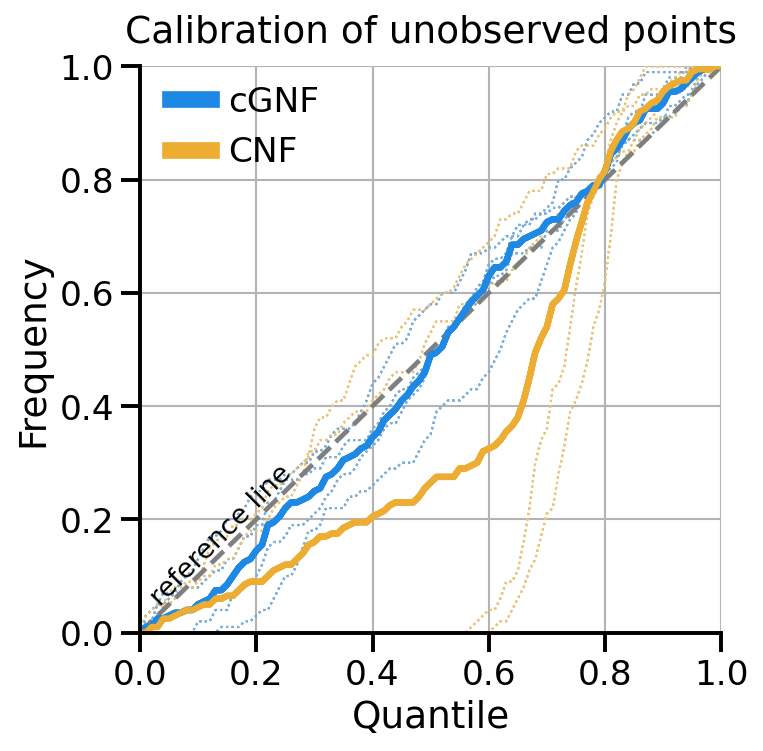

In [368]:
# sns.set_context('talk')
# with sns.axes_style('whitegrid'):
plt.figure(figsize=(5, 5), dpi=150)
for key in quantiles['cGNF']:

    plt.plot(quantiles['cGNF'][key]['quantiles'], np.stack(v_cgnf_uobs).T, c="#7CAEDA", alpha=1, zorder=1, lw=1, ls=":")
    plt.plot(quantiles['cGNF'][key]['quantiles'], np.median(np.stack(v_cgnf_uobs), axis=0), c=colors["cGNF"], alpha=1, zorder=2, lw=3, label='cGNF' if key == 'x' else None)

    plt.plot(quantiles['CNF'][key]['quantiles'], np.stack(v_cnf_uobs).T, c="#ECC477", alpha=1, zorder=1, lw=1, ls=":")
    plt.plot(quantiles['CNF'][key]['quantiles'], np.median(np.stack(v_cnf_uobs), axis=0), c=colors["CNF"], alpha=1, zorder=2, lw=3, label='CNF' if key == 'x' else None, ls="-")

plt.plot([0, 1], [0, 1], ls='--', c='tab:gray', zorder=1)
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlabel('Quantile')
plt.ylabel('Frequency')
plt.text(.01, .05, 'reference line', rotation=45, c='k', fontsize=13, zorder=10) #, weight="bold")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Calibration of unobserved points', y=1.02)

lgnd = plt.legend(loc=(0.028, .795), frameon=False, handletextpad=.5, handlelength=1.2)
for h in lgnd.legendHandles:
    h.set_linewidth(8.)
    
sns.despine(trim=True)
plt.gca().set_axisbelow(True)
plt.grid(ls="-", c=".7", lw=1., zorder=0)
    
# plt.savefig('./calibration_toy.pdf', dpi=100, bbox_inches='tight')
# plt.savefig('./calibration_toy.png', dpi=100, bbox_inches='tight')
plt.savefig('./calibration_toy.svg', dpi=100, bbox_inches='tight')

plt.show()